In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

from sklearn.model_selection import train_test_split

## Import dataset

In [2]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


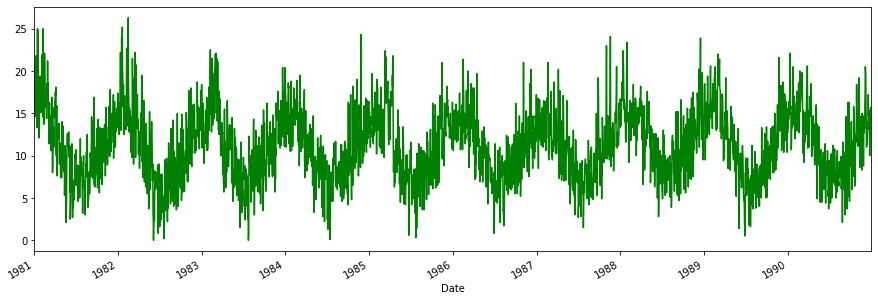

In [3]:
df.Temp.plot(figsize=(15,5), color='g');

## Dataset Splitting

In [4]:
## Pada data time series data tidak boleh dishuffle(diacak) 
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

## Dataset dan Dataloader

In [5]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [6]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, 'Temp', seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, 'Temp', seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



- N = Jumlah data
- S = Squence
- F = Feature

## Arsitektur dan config

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size,output_size, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [13]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size":1,
    "hidden_size":256,
    "num_layers":3,
    "dropout":0
})

## Training Preparation

In [14]:
model = LSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/lstm")

## Training

In [15]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 118.8396 | Test_cost  = 68.1010 | 




Epoch     2
Train_cost  = 42.9887 | Test_cost  = 28.5900 | 




Epoch     3
Train_cost  = 23.3649 | Test_cost  = 21.5528 | 




Epoch     4
Train_cost  = 20.2249 | Test_cost  = 19.8393 | 




Epoch     5
Train_cost  = 19.1602 | Test_cost  = 18.7665 | 




Epoch     6
Train_cost  = 18.0579 | Test_cost  = 18.1810 | 




Epoch     7
Train_cost  = 17.4266 | Test_cost  = 18.1139 | 




Epoch     8
Train_cost  = 17.2378 | Test_cost  = 18.0481 | 




Epoch     9
Train_cost  = 17.1165 | Test_cost  = 17.8338 | 




Epoch    10
Train_cost  = 16.9960 | Test_cost  = 17.6424 | 




Epoch    11
Train_cost  = 16.9243 | Test_cost  = 17.5503 | 




Epoch    12
Train_cost  = 16.8822 | Test_cost  = 17.5298 | 




Epoch    13
Train_cost  = 16.8534 | Test_cost  = 17.5391 | 
==> EarlyStop patience =  1 | Best test_cost: 17.5298




Epoch    14
Train_cost  = 16.8363 | Test_cost  = 17.5407 | 
==> EarlyStop patience =  2 | Best test_cost: 17.5298




Epoch    15
Train_cost  = 16.8229 | Test_cost  = 17.5208 | 




Epoch    16
Train_cost  = 16.8084 | Test_cost  = 17.4935 | 




Epoch    17
Train_cost  = 16.7933 | Test_cost  = 17.4724 | 




Epoch    18
Train_cost  = 16.7790 | Test_cost  = 17.4601 | 




Epoch    19
Train_cost  = 16.7660 | Test_cost  = 17.4525 | 




Epoch    20
Train_cost  = 16.7525 | Test_cost  = 17.4430 | 


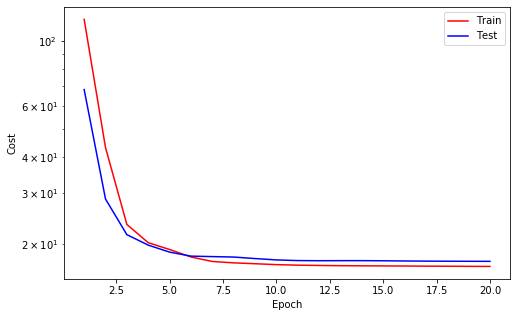



Epoch    21
Train_cost  = 16.7370 | Test_cost  = 17.4240 | 




Epoch    22
Train_cost  = 16.7225 | Test_cost  = 17.4024 | 




Epoch    23
Train_cost  = 16.7091 | Test_cost  = 17.3871 | 




Epoch    24
Train_cost  = 16.6969 | Test_cost  = 17.3777 | 




Epoch    25
Train_cost  = 16.6859 | Test_cost  = 17.3694 | 




Epoch    26
Train_cost  = 16.6754 | Test_cost  = 17.3593 | 




Epoch    27
Train_cost  = 16.6635 | Test_cost  = 17.3433 | 




Epoch    28
Train_cost  = 16.6495 | Test_cost  = 17.3239 | 




Epoch    29
Train_cost  = 16.6377 | Test_cost  = 17.3122 | 




Epoch    30
Train_cost  = 16.6270 | Test_cost  = 17.3045 | 




Epoch    31
Train_cost  = 16.6170 | Test_cost  = 17.2963 | 




Epoch    32
Train_cost  = 16.6070 | Test_cost  = 17.2864 | 




Epoch    33
Train_cost  = 16.5969 | Test_cost  = 17.2761 | 




Epoch    34
Train_cost  = 16.5865 | Test_cost  = 17.2663 | 




Epoch    35
Train_cost  = 16.5760 | Test_cost  = 17.2563 | 




Epoch    36
Train_cost  = 16.5654 | Test_cost  = 17.2465 | 




Epoch    37
Train_cost  = 16.5545 | Test_cost  = 17.2357 | 




Epoch    38
Train_cost  = 16.5428 | Test_cost  = 17.2231 | 




Epoch    39
Train_cost  = 16.5306 | Test_cost  = 17.2077 | 




Epoch    40
Train_cost  = 16.5172 | Test_cost  = 17.1911 | 


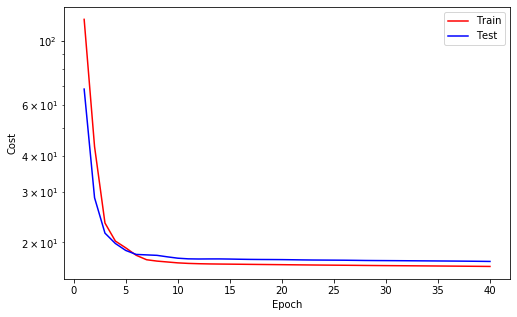



Epoch    41
Train_cost  = 16.5031 | Test_cost  = 17.1699 | 




Epoch    42
Train_cost  = 16.4846 | Test_cost  = 17.1498 | 




Epoch    43
Train_cost  = 16.4584 | Test_cost  = 17.1358 | 




Epoch    44
Train_cost  = 16.4383 | Test_cost  = 17.0936 | 




Epoch    45
Train_cost  = 16.4011 | Test_cost  = 17.0671 | 




Epoch    46
Train_cost  = 16.3782 | Test_cost  = 16.9875 | 




Epoch    47
Train_cost  = 16.3258 | Test_cost  = 16.9464 | 




Epoch    48
Train_cost  = 16.2658 | Test_cost  = 16.8804 | 




Epoch    49
Train_cost  = 16.2120 | Test_cost  = 16.8540 | 




Epoch    50
Train_cost  = 16.1626 | Test_cost  = 16.7559 | 




Epoch    51
Train_cost  = 16.0874 | Test_cost  = 16.6849 | 




Epoch    52
Train_cost  = 15.9930 | Test_cost  = 16.5611 | 




Epoch    53
Train_cost  = 15.9053 | Test_cost  = 16.4498 | 




Epoch    54
Train_cost  = 15.8232 | Test_cost  = 16.3722 | 




Epoch    55
Train_cost  = 15.7230 | Test_cost  = 16.1740 | 




Epoch    56
Train_cost  = 15.4843 | Test_cost  = 15.6727 | 




Epoch    57
Train_cost  = 15.2098 | Test_cost  = 15.4464 | 




Epoch    58
Train_cost  = 14.9265 | Test_cost  = 15.1204 | 




Epoch    59
Train_cost  = 14.6675 | Test_cost  = 14.8629 | 




Epoch    60
Train_cost  = 14.4025 | Test_cost  = 14.4535 | 


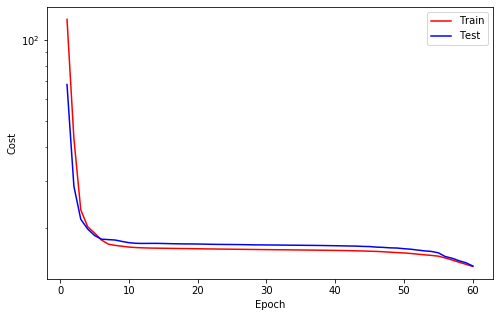



Epoch    61
Train_cost  = 14.1015 | Test_cost  = 14.2858 | 




Epoch    62
Train_cost  = 13.9318 | Test_cost  = 14.0476 | 




Epoch    63
Train_cost  = 13.7684 | Test_cost  = 13.9891 | 




Epoch    64
Train_cost  = 13.6858 | Test_cost  = 13.5300 | 




Epoch    65
Train_cost  = 13.3666 | Test_cost  = 13.4531 | 




Epoch    66
Train_cost  = 13.1069 | Test_cost  = 13.2016 | 




Epoch    67
Train_cost  = 12.9760 | Test_cost  = 12.9114 | 




Epoch    68
Train_cost  = 12.8124 | Test_cost  = 12.8648 | 




Epoch    69
Train_cost  = 12.7501 | Test_cost  = 12.8065 | 




Epoch    70
Train_cost  = 12.6091 | Test_cost  = 12.4805 | 




Epoch    71
Train_cost  = 12.3755 | Test_cost  = 12.2521 | 




Epoch    72
Train_cost  = 12.1318 | Test_cost  = 11.9043 | 




Epoch    73
Train_cost  = 11.9145 | Test_cost  = 11.7396 | 




Epoch    74
Train_cost  = 11.7864 | Test_cost  = 11.6105 | 




Epoch    75
Train_cost  = 11.6720 | Test_cost  = 11.5545 | 




Epoch    76
Train_cost  = 11.6066 | Test_cost  = 11.5274 | 




Epoch    77
Train_cost  = 11.5118 | Test_cost  = 11.1021 | 




Epoch    78
Train_cost  = 11.1907 | Test_cost  = 10.8682 | 




Epoch    79
Train_cost  = 10.9439 | Test_cost  = 10.6892 | 




Epoch    80
Train_cost  = 10.7754 | Test_cost  = 10.5025 | 


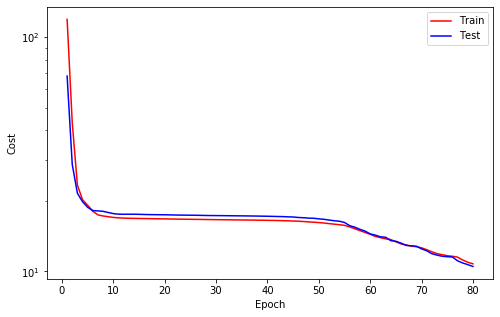



Epoch    81
Train_cost  = 10.5850 | Test_cost  = 10.3118 | 




Epoch    82
Train_cost  = 10.4143 | Test_cost  = 10.0490 | 




Epoch    83
Train_cost  = 10.1939 | Test_cost  = 9.7977 | 




Epoch    84
Train_cost  = 9.9806 | Test_cost  = 9.5853 | 




Epoch    85
Train_cost  = 9.7648 | Test_cost  = 9.3326 | 




Epoch    86
Train_cost  = 9.4132 | Test_cost  = 9.0635 | 




Epoch    87
Train_cost  = 9.0297 | Test_cost  = 8.3026 | 




Epoch    88
Train_cost  = 8.5717 | Test_cost  = 7.8692 | 




Epoch    89
Train_cost  = 8.2469 | Test_cost  = 7.5025 | 




Epoch    90
Train_cost  = 7.9405 | Test_cost  = 6.9652 | 




Epoch    91
Train_cost  = 7.4498 | Test_cost  = 6.5225 | 




Epoch    92
Train_cost  = 7.1517 | Test_cost  = 6.2134 | 




Epoch    93
Train_cost  = 6.8561 | Test_cost  = 6.0084 | 




Epoch    94
Train_cost  = 6.7150 | Test_cost  = 5.9359 | 




Epoch    95
Train_cost  = 6.5668 | Test_cost  = 5.7613 | 




Epoch    96
Train_cost  = 6.4664 | Test_cost  = 5.7560 | 




Epoch    97
Train_cost  = 6.4244 | Test_cost  = 5.5824 | 




Epoch    98
Train_cost  = 6.3965 | Test_cost  = 5.4555 | 




Epoch    99
Train_cost  = 6.2942 | Test_cost  = 5.3620 | 




Epoch   100
Train_cost  = 6.2291 | Test_cost  = 5.3489 | 


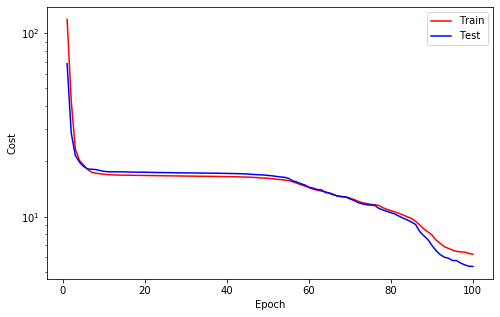



Epoch   101
Train_cost  = 6.1941 | Test_cost  = 5.3049 | 




Epoch   102
Train_cost  = 6.1700 | Test_cost  = 5.3442 | 
==> EarlyStop patience =  1 | Best test_cost: 5.3049




Epoch   103
Train_cost  = 6.1717 | Test_cost  = 5.2193 | 




Epoch   104
Train_cost  = 6.0878 | Test_cost  = 5.2236 | 
==> EarlyStop patience =  1 | Best test_cost: 5.2193




Epoch   105
Train_cost  = 6.0779 | Test_cost  = 5.2237 | 
==> EarlyStop patience =  2 | Best test_cost: 5.2193




Epoch   106
Train_cost  = 6.0738 | Test_cost  = 5.2041 | 




Epoch   107
Train_cost  = 6.0444 | Test_cost  = 5.1599 | 




Epoch   108
Train_cost  = 6.0071 | Test_cost  = 5.1352 | 




Epoch   109
Train_cost  = 5.9989 | Test_cost  = 5.1646 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1352




Epoch   110
Train_cost  = 5.9948 | Test_cost  = 5.1500 | 
==> EarlyStop patience =  2 | Best test_cost: 5.1352




Epoch   111
Train_cost  = 5.9878 | Test_cost  = 5.1723 | 
==> EarlyStop patience =  3 | Best test_cost: 5.1352




Epoch   112
Train_cost  = 5.9984 | Test_cost  = 5.1179 | 




Epoch   113
Train_cost  = 5.9493 | Test_cost  = 5.0691 | 




Epoch   114
Train_cost  = 5.9157 | Test_cost  = 5.0991 | 
==> EarlyStop patience =  1 | Best test_cost: 5.0691




Epoch   115
Train_cost  = 5.8952 | Test_cost  = 5.0658 | 




Epoch   116
Train_cost  = 5.8774 | Test_cost  = 5.0975 | 
==> EarlyStop patience =  1 | Best test_cost: 5.0658




Epoch   117
Train_cost  = 5.8493 | Test_cost  = 5.0761 | 
==> EarlyStop patience =  2 | Best test_cost: 5.0658




Epoch   118
Train_cost  = 5.8487 | Test_cost  = 5.0469 | 




Epoch   119
Train_cost  = 5.8027 | Test_cost  = 5.1000 | 
==> EarlyStop patience =  1 | Best test_cost: 5.0469




Epoch   120
Train_cost  = 5.8254 | Test_cost  = 5.0554 | 


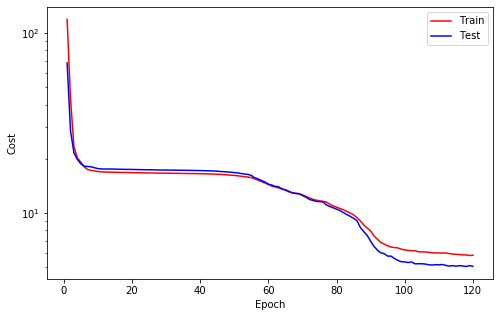

==> EarlyStop patience =  2 | Best test_cost: 5.0469




Epoch   121
Train_cost  = 5.7651 | Test_cost  = 5.0667 | 
==> EarlyStop patience =  3 | Best test_cost: 5.0469




Epoch   122
Train_cost  = 5.7504 | Test_cost  = 5.0727 | 
==> EarlyStop patience =  4 | Best test_cost: 5.0469




Epoch   123
Train_cost  = 5.7410 | Test_cost  = 5.0953 | 
==> EarlyStop patience =  5 | Best test_cost: 5.0469
==> Execute Early Stopping at epoch: 123 | Best test_cost: 5.0469
==> Best model is saved at model/lstm


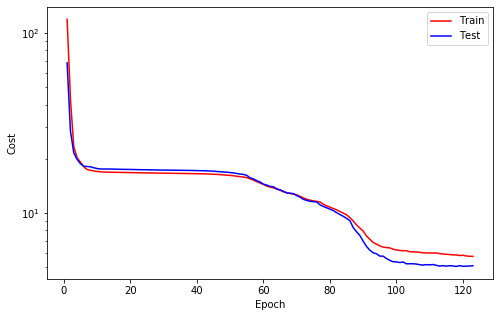

In [16]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [17]:
from utils import data4pred, pred4pred

In [18]:
train_forecast_set = TimeSeriesDataset(ts_train, 'Temp', 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, 'Temp', 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

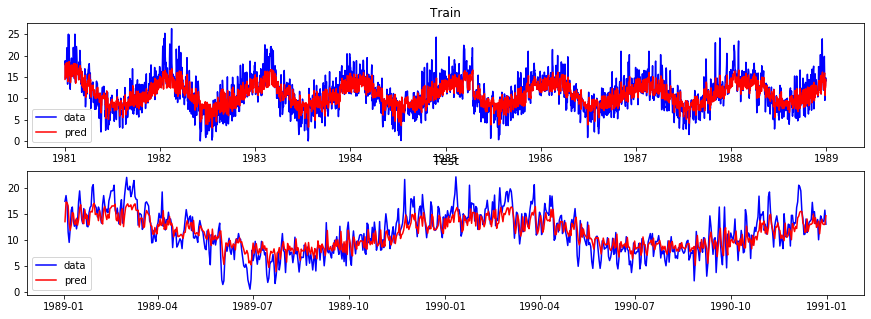

In [19]:
# Data For Pred
plt.figure(figsize=(15,5))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title('Train')

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

Text(0.5, 1.0, 'Test')

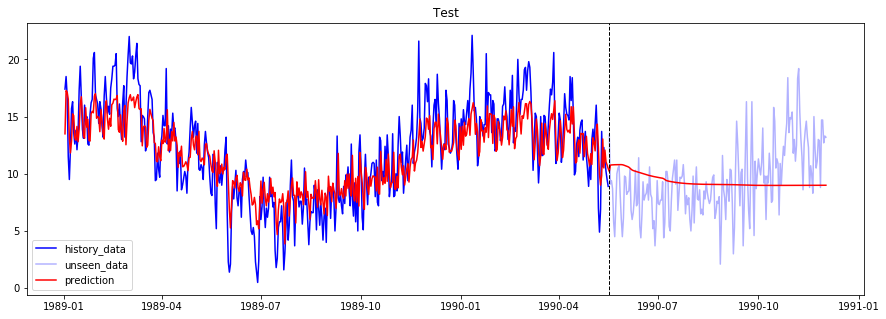

In [20]:
# Pred for pred
plt.figure(figsize=(15,5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

#### Umumnya pred for pred hanya dapat memprediksi 2 hari kedepan. untuk hari selanjutnya tidak dipakai karena terjadi domino effect yang terjadi apabila disuatu hari tersebut terjadi kesalahan maka hari selanjutnya akan menjadi salah terus 